In [1]:
import numpy as np
import math 
import random

import matplotlib.pyplot as plt
from plotnine import * 
import pandas as pd
%matplotlib inline

from mesa import Model, Agent
from mesa.time import SimultaneousActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
from mesa.batchrunner import BatchRunner

In [2]:
def get_distance(pos_1, pos_2):
    """ Get the distance between two point

    Args:
        pos_1, pos_2: Coordinate tuples for both points.

    """
    x1, y1 = pos_1
    x2, y2 = pos_2
    dx = x1 - x2
    dy = y1 - y2
    return math.sqrt(dx ** 2 + dy ** 2)

Used in having Boats return to their Home.

# Agents

In [3]:
class Ocean(Agent):
    def __init__(self, unique_id, pos, model):
        super().__init__(unique_id, model)
        self.pos = pos

    def get_pos(self):
        return self.pos

Basic enviormental agent used for movement mostly.

In [4]:
class Lobster(Agent):

    def __init__(self, unique_id, pos, model, moore=True):
        super().__init__(unique_id, model)
        self.pos = pos
        self.state = "Wander"
        self.moore = moore
        self.timer = random.randint(0, 10)
        self.count = 0
        self.counts = [0]
        self.models = model
        self.schedule = SimultaneousActivation(self.models)
        self.turn = 0


    def step(self):
        self.turn += 1
        self.move_north()
        self.count += 1
        self.counts.append(self.count)

    def heat_locater(self):
        heat = [n for n in self.model.grid.get_neighbors(self.pos, self.moore) if type(n) is Heat_Spot]
        for h in heat:
            heat_p = h.track()
            return heat_p

    def move_north(self):
        moves = []
        heat = self.heat_locater()
        if heat is not None:
            next_moves = self.model.grid.get_neighborhood(self.pos, self.moore, True)
            for move in next_moves:
                if move[1] not in heat:
                    moves.append(move)
        if len(moves) == 0:
            return None
        next_move = random.choice(moves)
        self.model.grid.move_agent(self, next_move)
        self.neighbor_move()



    def neighbor_move(self):
        lobsters = [n for n in self.model.grid.get_neighbors(self.pos, self.moore) if type(n) is Lobster]
        for l in lobsters:
            if l.pos[1] > self.pos[1]:
                l.neighbor_move()
        if random.random() < 0.25:
            if self.pos[1]+1 < self.model.size():
                self.model.grid.move_agent(self, (self.pos[0],self.pos[1]+1))

The Lobster agent will stay above the heat line and can occasionally move up depending on it's neighbors from the neighbor_move method. If caught, it will change its state to "Caught" and will no longer be catchable. 

In [5]:
class Boat(Agent):

    def __init__(self, unique_id, pos, model, home, moore=True):
        super().__init__(unique_id, model)
        self.home = home
        self.pos = pos
        self.size = "Small"
        self.state = "Search"
        self.moore = moore
        self.amount = 0
        self.turn = 0
        self.unable = False

    def step(self):
        self.turn += 1
        if self.state == "Search":
            if (self.size == "Small" and self.pos[1]<26) or self.size == "Big":
                if self.pos[1] < 4 + self.turn//5:
                    self.smart_move()
                else:
                    self.random_move()
                if self.catch():
                    if self.able_to_return():
                        self.state = "Return"
            else:
                self.unable = True
                self.state = "Return"
        else:
            if self.pos == self.home.pos:
                if not self.unable:
                    self.state = "Search"
                if self.size == "Big":
                    self.model.big_count += self.amount
                else:
                    self.model.small_count += self.amount
                self.amount = 0
                
            else:
                self.return_home()


    def able_to_return(self):
        if self.size == "Big" and self.amount == 10:
            return True
        elif self.size == "Small" and self.amount == 5:
            return True
        else:
            return False

    def return_home(self):
        """
        This makes the Boat able to return to Port
        """
        neighbors = [n.get_pos() for n in self.model.grid.get_neighbors(self.pos, self.moore) if type(n) is Ocean]

        # Narrow down to the nearest ones to home
        min_dist = min([get_distance(self.home.pos, pos) for pos in neighbors])
        final_candidates = [
            pos for pos in neighbors if get_distance(self.home.pos, pos) == min_dist
        ]
        self.random.shuffle(final_candidates)
        self.model.grid.move_agent(self, final_candidates[0])


    def catch(self) -> bool:
        neighbors = self.model.grid.get_neighbors(self.pos, self.moore, True)
        for n in neighbors:
            if type(n) == Lobster:
                if n.state == "Wander":
                    self.model.grid.move_agent(self,n.pos)
                    self.amount += 1
                    n.state = "Caught"
                    return True


        return False

    def random_move(self):
        while True:
            try:
                next_moves = self.model.grid.get_neighborhood(self.pos, self.moore, True)
                next_move = random.choice(next_moves)
                self.model.grid.move_agent(self, next_move)
            except:
                pass
            else:
                break

    def smart_move(self):
        x = self.pos[0]
        y = self.pos[1]
        self.model.grid.move_agent(self, (x, y+1))
        
    def in_storage(self):
        self.model.big_count += self.amount

The Boat agent comes in two sizes, big and small. Small boats will not be able to advance past halfway up the model while big boats can continue the entire time. Boats will move straight north until reaching the heat line, then will move randomly. Once they reach their maximum capacity of lobster, they will return to their home in order to drop the lobsters off.

In [6]:
class Home(Agent):
    """
    The home of the ants, recording how much food has been harvested.
    """

    def __init__(self, unique_id, pos, model, size):
        """
        Records the unique_id with the super, and saves the pos.
        Initializes the food amount to 0.
        """
        super().__init__(unique_id, model)
        self.pos = pos
        self.amount = 0
        self.size = size


This serves as the port for some boats, and is where they will need to go to unload their lobster. Once here, their lobsters are added to the total amount.

In [7]:
class Heat_Spot(Agent):

    def __init__(self, unique_id, model, pos, moore=True):
        super().__init__(unique_id, model)
        self.moore = moore
        self.pos = pos
        self.count = 4
        self.turn = 0
        self.tracks = [0,1,2,3,4]

    def step(self):
        self.turn += 1
        if self.turn%5 == 0:
            self.model.grid.move_agent(self, (self.pos[0], self.count))
            self.count += 1
            self.tracks.append(self.count)

    def track(self):
        return self.tracks

The Heat_Spot agent keeps track of where it has been so that lobsters cannot move there. It will move north every 5 steps.

In [8]:
# Model

In [9]:
class World(Model):
    def __init__(self, height=53, width=53, num_lobsters=300, num_boats=20, movement=0.3, density=0.6, sim_length=244):
        super().__init__()
        # All the params for the model
        self.height = height
        self.width = width
        self.density = density
        self.lobster = num_lobsters
        self.boat = num_boats
        self.sim_length = sim_length
        self.movement = movement

        # Holds all the local lobsters and boats in the model
        self.lobster_loc = []
        self.all_boat_loc = []
        self.small_boat_loc = []
        self.big_boat_loc = []
        self.heat_spot_loc = []

        # Advances and Plots out the model
        self.schedule = SimultaneousActivation(self)
        self.grid = MultiGrid(height, width, torus=False)
        
        self.dc_lobster = DataCollector({"Wild Lobster": lambda m: self.lobster_count})
        self.dc_big = DataCollector({"Big Catch": lambda m: self.big_count})
        self.dc_small = DataCollector({"Small Catch": lambda m: self.small_count})

        self.lobster_count = 0
        self.big_count = 0
        self.small_count = 0

        port1 = (13, 0)
        port2 = (26, 0)
        port3 = (39, 0)

        Port1 = self.big_port = Home(self.next_id(), port1, self, "big")
        self.grid.place_agent(Port1, port1)
        self.schedule.add(Port1)
        Port2 = self.big_port = Home(self.next_id(), port2, self, "big")
        self.grid.place_agent(Port2, port2)
        self.schedule.add(Port2)
        Port3 = self.big_port = Home(self.next_id(), port3, self, "big")
        self.grid.place_agent(Port3, port3)
        self.schedule.add(Port3)

        for (contents, x, y) in self.grid.coord_iter():
            cell = Ocean(self.next_id(), (x, y), self)
            self.grid.place_agent(cell, (x, y))
            self.schedule.add(cell)
        for i in range(self.width):
            new_loc = (i, 3)
            heat = Heat_Spot(self.next_id(), self, new_loc)
            self.grid.place_agent(heat, new_loc)
            self.schedule.add(heat)


        for boat in range(self.boat):
            new_loc = (random.randint(0, self.width-1), random.randint(0, 3))
            r = random.random()
            x = random.random()
            if x < .33:
                new_boat = Boat(self.next_id(), new_loc, self, Port1)
            elif x < .66:
                new_boat = Boat(self.next_id(), new_loc, self, Port2)
            else:
                new_boat = Boat(self.next_id(), new_loc, self, Port3)
            if r < self.density:
                new_boat.size = "Small"
                self.small_boat_loc.append(new_boat)
            elif r > self.density:
                new_boat.size = "Big"
                self.big_boat_loc.append(new_boat)
            self.grid.place_agent(new_boat, new_loc)
            self.schedule.add(new_boat)

        for lobster in range(self.lobster):
            new_loc = (random.randint(0, self.height-1), random.randint(4, self.height-1))
            new_lob = Lobster(self.next_id(), new_loc, self)
            self.grid.place_agent(new_lob, new_loc)
            self.schedule.add(new_lob)

        self.running = True

    def size(self):
        return self.width
    def step(self):
        """
        Advance the model by one step.
        """
        self.schedule.step()
        self.count_lobster()
        # If the model passes the simulation length the simulation ends
        self.dc_lobster.collect(self)
        self.dc_big.collect(self)
        self.dc_small.collect(self)
        if self.schedule.time == self.sim_length:
            for agent in self.schedule.agents:
                if type(agent) == Boat:
                    agent.in_storage()
            self.dc_lobster.collect(self)
            self.dc_big.collect(self)
            self.dc_small.collect(self)
            self.running = False

    def count_lobster(self):
        self.lobster_count = 0
        for x in range(self.width):
            for y in range(self.height-1):
                spot_agents = self.grid.get_cell_list_contents([(x, y)])
                for agent in spot_agents:
                    if type(agent) == Lobster:
                        if agent.state == "Wander":
                            self.lobster_count += 1


The World is the model in which the simulation takes place. After assigning homes to boats it will then placing Oceans, Lobsters, Boats, Heat_spots, and Homes. Each step it will collect data and check if it is the end of the simulation. It will also keep track of its data using the count_lobster method and it's own self.big_count and self.small_count which are changed in the Boat class.

# Simulation

In [10]:
lobsters = World()
lobsters.run_model()
results_lobster = lobsters.dc_lobster.get_model_vars_dataframe()
results_big = lobsters.dc_big.get_model_vars_dataframe()
results_small = lobsters.dc_small.get_model_vars_dataframe()

In [11]:
results = pd.concat([results_lobster, results_big, results_small], axis=1, sort=False)

In [12]:
results

,Wild Lobster,Big Catch,Small Catch
0,291,0,0
1,291,0,0
2,288,0,0
3,286,0,0
4,282,0,0
...,...,...,...
240,0,70,67
241,0,80,67
242,0,80,67
243,0,80,67


The results dataframe shows the total wild lobster population and how many lobsters were caught by big and small boats in total at each time step. 

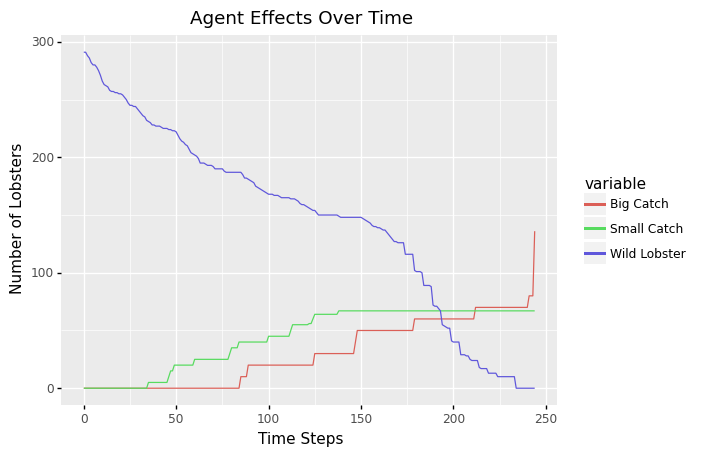

<ggplot: (-9223371905757854268)>

In [13]:
results["time"] = np.linspace(0, len(results) - 1, len(results))
resultsmelt = pd.melt(results, id_vars=["time"], value_vars=["Wild Lobster", "Big Catch", "Small Catch"])
ggplot(resultsmelt, aes(x="time", y="value", color="variable")) \
+ geom_line() \
+ labs(title="Agent Effects Over Time", x = "Time Steps", y = "Number of Lobsters")

It is in this model that we can see clearly what happened during the simulation. While lobsters would be forcefully displaced due to the rising temperatures, fishing is also the reason for lobster population declining. As can be seen, the small catch no longer increases after 122 time steps. Small boats will often hold the lead due to them returning home more often and getting their total counted more, but because of the *in_storage* method from the Boat class, the big boats always have a spike once the simulation is over.

# Half Simulation

In [14]:
class World(Model):
    def __init__(self, height=53, width=53, num_lobsters=300, num_boats=20, movement=0.3, density=0.6, sim_length=122):
        super().__init__()
        # All the params for the model
        self.height = height
        self.width = width
        self.density = density
        self.lobster = num_lobsters
        self.boat = num_boats
        self.sim_length = sim_length
        self.movement = movement

        # Holds all the local lobsters and boats in the model
        self.lobster_loc = []
        self.all_boat_loc = []
        self.small_boat_loc = []
        self.big_boat_loc = []
        self.heat_spot_loc = []

        # Advances and Plots out the model
        self.schedule = SimultaneousActivation(self)
        self.grid = MultiGrid(height, width, torus=False)
        
        self.dc_lobster = DataCollector({"Wild Lobster": lambda m: self.lobster_count})
        self.dc_big = DataCollector({"Big Catch": lambda m: self.big_count})
        self.dc_small = DataCollector({"Small Catch": lambda m: self.small_count})

        self.lobster_count = 0
        self.big_count = 0
        self.small_count = 0

        port1 = (13, 0)
        port2 = (26, 0)
        port3 = (39, 0)

        Port1 = self.big_port = Home(self.next_id(), port1, self, "big")
        self.grid.place_agent(Port1, port1)
        self.schedule.add(Port1)
        Port2 = self.big_port = Home(self.next_id(), port2, self, "big")
        self.grid.place_agent(Port2, port2)
        self.schedule.add(Port2)
        Port3 = self.big_port = Home(self.next_id(), port3, self, "big")
        self.grid.place_agent(Port3, port3)
        self.schedule.add(Port3)

        for (contents, x, y) in self.grid.coord_iter():
            cell = Ocean(self.next_id(), (x, y), self)
            self.grid.place_agent(cell, (x, y))
            self.schedule.add(cell)
        for i in range(self.width):
            new_loc = (i, 3)
            heat = Heat_Spot(self.next_id(), self, new_loc)
            self.grid.place_agent(heat, new_loc)
            self.schedule.add(heat)


        for boat in range(self.boat):
            new_loc = (random.randint(0, self.width-1), random.randint(0, 3))
            r = random.random()
            x = random.random()
            if x < .33:
                new_boat = Boat(self.next_id(), new_loc, self, Port1)
            elif x < .66:
                new_boat = Boat(self.next_id(), new_loc, self, Port2)
            else:
                new_boat = Boat(self.next_id(), new_loc, self, Port3)
            if r < self.density:
                new_boat.size = "Small"
                self.small_boat_loc.append(new_boat)
            elif r > self.density:
                new_boat.size = "Big"
                self.big_boat_loc.append(new_boat)
            self.grid.place_agent(new_boat, new_loc)
            self.schedule.add(new_boat)

        for lobster in range(self.lobster):
            new_loc = (random.randint(0, self.height-1), random.randint(4, self.height-1))
            new_lob = Lobster(self.next_id(), new_loc, self)
            self.grid.place_agent(new_lob, new_loc)
            self.schedule.add(new_lob)

        self.running = True

    def size(self):
        return self.width
    def step(self):
        """
        Advance the model by one step.
        """
        self.schedule.step()
        self.count_lobster()
        # If the model passes the simulation length the simulation ends
        self.dc_lobster.collect(self)
        self.dc_big.collect(self)
        self.dc_small.collect(self)
        if self.schedule.time == self.sim_length:
            self.running = False

    def count_lobster(self):
        self.lobster_count = 0
        for x in range(self.width):
            for y in range(self.height-1):
                spot_agents = self.grid.get_cell_list_contents([(x, y)])
                for agent in spot_agents:
                    if type(agent) == Lobster:
                        if agent.state == "Wander":
                            self.lobster_count += 1


In [15]:
lobsters = World()
lobsters.run_model()
results_lobster = lobsters.dc_lobster.get_model_vars_dataframe()
results_big = lobsters.dc_big.get_model_vars_dataframe()
results_small = lobsters.dc_small.get_model_vars_dataframe()

In [16]:
results = pd.concat([results_lobster, results_big, results_small], axis=1, sort=False)

In [17]:
results

,Wild Lobster,Big Catch,Small Catch
0,294,0,0
1,293,0,0
2,293,0,0
3,291,0,0
4,288,0,0
...,...,...,...
117,168,40,47
118,167,40,47
119,167,40,47
120,167,50,47


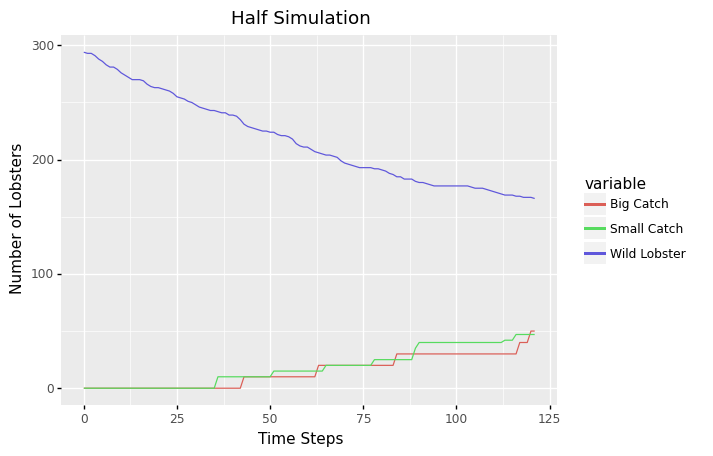

<ggplot: (-9223371905757094292)>

In [18]:
results["time"] = np.linspace(0, len(results) - 1, len(results))
resultsmelt = pd.melt(results, id_vars=["time"], value_vars=["Wild Lobster", "Big Catch", "Small Catch"])
ggplot(resultsmelt, aes(x="time", y="value", color="variable")) \
+ geom_line() \
+ labs(title="Half Simulation", x = "Time Steps", y = "Number of Lobsters")

We can see that the numbers are a lot more fair once the big boats do not get anymore fishing time once the lobsters move too far north. This shows that there is a significant difference when lobsters get too far away for certain fishermen to catch and that our theory is correct of the rising temperatures being a threat to the lobster economy. 